"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [91]:
#https://discourse.pymc.io/t/nuts-uses-all-cores/909/9


import os
os.environ["MKL_NUM_THREADS"]='1'
os.environ["OMP_NUM_THREADS"]='1'

In [92]:
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum
import arviz as az
import pandas as pd
import seaborn as sns

In [93]:
# np.__config__.show()

In [94]:
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

[ 19  53  82 106 122 154 161 168]
[  0  19  53  82 106 122 154 161 168 200]
(10, 9)
(10, 200)


Text(0, 0.5, 'Neuron # (Channels)')

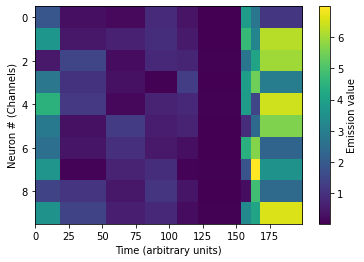

In [274]:
# Some poisson spiking
length = 200
states = 9
fit = int(1e5)
samples = 2000
idx = np.arange(length)

true_tau = np.cumsum(np.random.random(states))
true_tau /= np.max(true_tau)
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)
state_inds = np.concatenate([np.zeros((1)),true_tau])
state_inds = np.vectorize(np.int)(state_inds)
true_tau = true_tau[:-1]

nrns = 10
lambda_multipliers = np.random.random(states) * 10
true_lambda = np.random.random((nrns,states))
true_lambda = true_lambda * lambda_multipliers[np.newaxis,:]

print(true_tau)
print(state_inds)
print(true_lambda.shape)

true_r = np.zeros((nrns,length))
print(true_r.shape)
for num, val in enumerate(true_lambda.T):
    true_r[:,state_inds[num]:state_inds[num+1]] = val[:,np.newaxis]
  
plt.imshow(true_r,aspect='auto', interpolation='nearest');plt.colorbar(label = 'Emission value')
plt.xlabel('Time (arbitrary units)')
plt.ylabel("Neuron # (Channels)")

In [275]:
# Total length of data
length = 200
# Index vector timebins in data
idx = np.arange(length)
# Number of simultaneously recorded neurons a.k.a "channels"
nrns = 10
# Max number of states
changes = 10

with pm.Model() as dpp_model:
    
    # ===================
    # Emissions Variables
    # ===================
    lambda_latent = pm.Normal('lambda', 
                    mu = 0, sigma = 10, 
                    shape = (nrns,changes))

    # =====================
    # Changepoint Variables
    # =====================
    
    # Hyperpriors on alpha
    a_gamma = pm.Gamma('a_gamma',10,1)
    b_gamma = pm.Gamma('b_gamma',1.5,1)
    
    # Concentration parameter for beta
    alpha = pm.Gamma('alpha', a_gamma, b_gamma)
    
    # Draw beta's to calculate stick lengths
    beta = pm.Beta('beta', 1, alpha, shape = changes)
    
    # Calculate stick lengths using stick_breaking process
    w_raw = pm.Deterministic('w_raw', stick_breaking(beta))
    
    # Make sure lengths add to 1, and scale to length of data
    w_latent = pm.Deterministic('w_latent', w_raw / w_raw.sum())
    tau = pm.Deterministic('tau', tt.cumsum(w_latent * length)[:-1])
    
    # Weight stack to assign lambda's to point in time
    weight_stack = tt.nnet.sigmoid(idx[np.newaxis,:]-tau[:,np.newaxis])
    weight_stack = tt.concatenate([np.ones((1,length)),weight_stack],axis=0)
    inverse_stack = 1 - weight_stack[1:]
    inverse_stack = tt.concatenate([inverse_stack, np.ones((1,length))],axis=0)
    weight_stack = np.multiply(weight_stack,inverse_stack)

    # Create timeseries for latent variable (mean emission)
    lambda_ = pm.Deterministic('lambda_', 
                               tt.tensordot(
                                   lambda_latent,
                                   weight_stack,
                                   axes=(1,0)
                               )
                              )
    
    # Likelihood for observations
    observation = pm.Normal("obs", mu = lambda_, sigma = 0.1, observed=true_r)

In [276]:
with dpp_model:
    spp = pm.sample_prior_predictive(samples = 5000)

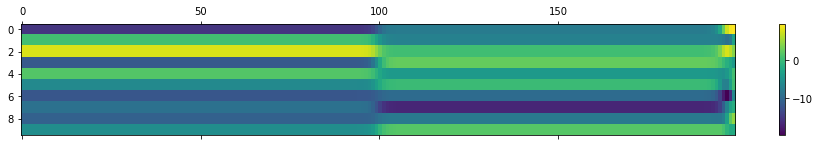

In [277]:
plt.matshow(spp['lambda_'][0], aspect='auto');plt.colorbar()

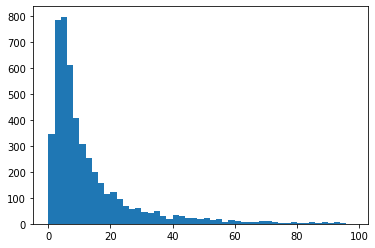

In [278]:
plt.hist(spp['alpha'],bins = np.arange(0,100,2));

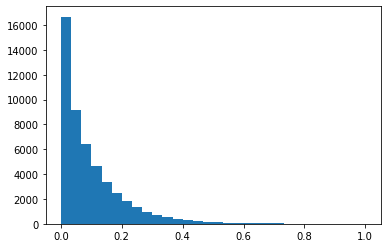

In [279]:
plt.hist(spp['w_latent'].flatten(), bins = 30);

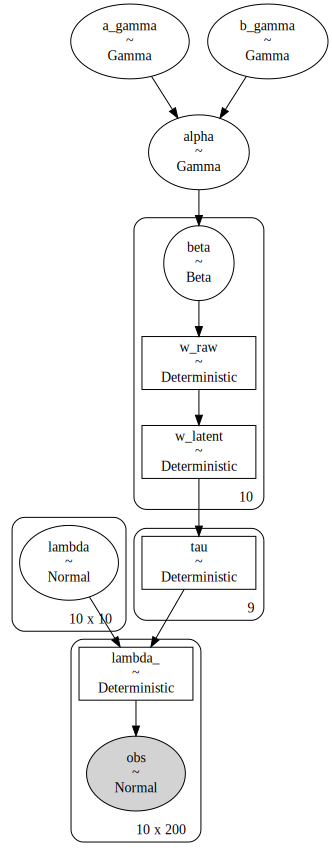

In [280]:
pm.model_to_graphviz(dpp_model)

In [281]:
with dpp_model:
    #         dpp_trace = pm.sample()
    dpp_trace = pm.sample(
                        tune = 500,
                        draws = 500, 
                          target_accept = 0.95,
                         chains = 24,
                         cores = 24,
                        return_inferencedata=False)
    
    #dpp_trace = pm.sample_smc(parallel = False)
    
#     inference = pm.ADVI('full-rank')
#     approx = pm.fit(n=160000, method=inference)
#     dpp_trace = approx.sample(draws=2000)
#     hist = -approx.hist[-50000:]
#     plt.plot(hist)
#     box_kern = np.ones(500)/500
#     plt.plot(np.convolve(hist,box_kern, mode='valid'))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (24 chains in 24 jobs)
NUTS: [beta, alpha, b_gamma, a_gamma, lambda]


Sampling 24 chains for 500 tune and 500 draw iterations (12_000 + 12_000 draws total) took 305 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8781313461511854, but should be close to 0.95. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8811876985919405, but should be close to 0.95. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or repara

In [282]:
# with dpp_model:
#     az_trace = az.from_pymc3(dpp_trace)
    
# ax = az.plot_trace(az_trace, compact=True, kind="rank_vlines")

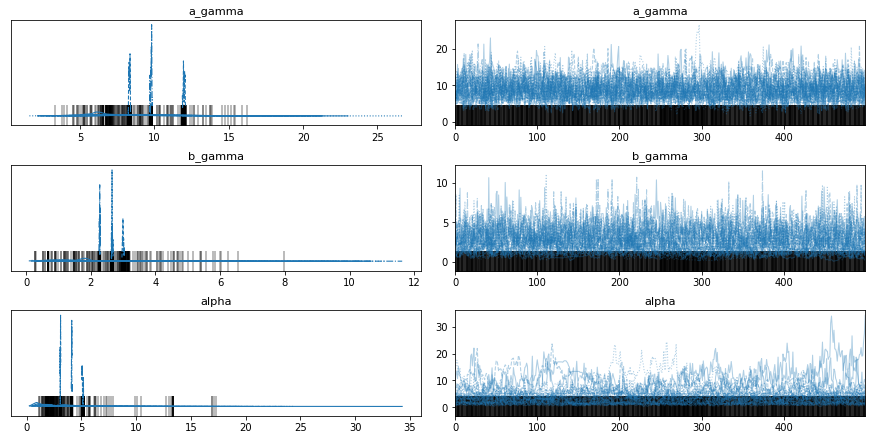

In [283]:
with dpp_model:
    pm.traceplot(dpp_trace, var_names = ['a_gamma','b_gamma','alpha']);

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/arviz/plots/pairplot.py:228: UserWarning: Divergences data not found, plotting without divergences. Make sure the sample method provides divergences data and that it is present in the `diverging` field of `sample_stats` or `sample_stats_prior` or set divergences=False
  UserWarning,


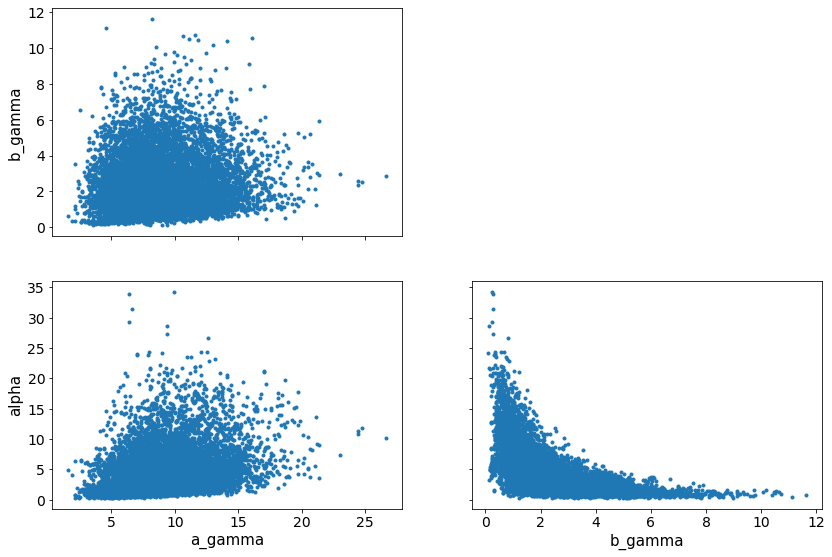

In [284]:
with dpp_model:
    pm.pairplot(dpp_trace, var_names = ['a_gamma','b_gamma','alpha'], divergences = True);

In [285]:
dpp_trace['w_latent'].shape

(12000, 10)

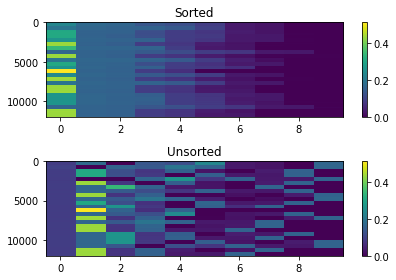

In [286]:
#sorted_lens = np.sort(dpp_trace['w_latent'],axis=-1)[:,::-1]
#w_latent_samples = dpp_trace.posterior.data_vars['w_latent'].values
w_latent_samples = dpp_trace['w_latent']
#cat_w_latent_samples = np.concatenate(w_latent_samples)
cat_w_latent_samples = w_latent_samples
sorted_lens = np.sort(cat_w_latent_samples,axis=-1)[:,::-1]
mean_lens = sorted_lens.mean(axis=0)
std_lens = sorted_lens.std(axis=0)

fig,ax = plt.subplots(2,1)
im1 = ax[0].imshow(sorted_lens, interpolation='nearest', aspect= 'auto')
im2 = ax[1].imshow(cat_w_latent_samples, interpolation='nearest', aspect= 'auto')
fig.colorbar(im1, ax=ax[0])
fig.colorbar(im2, ax=ax[1])
ax[0].set_title('Sorted')
ax[1].set_title('Unsorted')
plt.tight_layout()

In [287]:
# ppc_samples = 12*750
# dpp_ppc = pm.sample_posterior_predictive(dpp_trace, 
#                                          samples = ppc_samples, 
#                                          model = dpp_model,
#                                         var_names = ['alpha', 'w_latent'])

In [288]:
sorted_w_latent = np.stack(np.array_split(np.sort(w_latent_samples,axis=-1)[...,::-1],16,axis=0))
mean_sorted = np.mean(sorted_w_latent, axis = 1)

all_state_edges = np.concatenate([[0],true_tau,[length]])
state_durations = np.abs(np.diff(all_state_edges))
sorted_state_durations = np.sort(state_durations / length)[::-1]
shortest_state = sorted_state_durations[-1]

In [289]:
sorted_w_latent.shape

(16, 750, 10)

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 68.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 37.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/abuzarmahmood/anaconda3/lib/python3.6/s

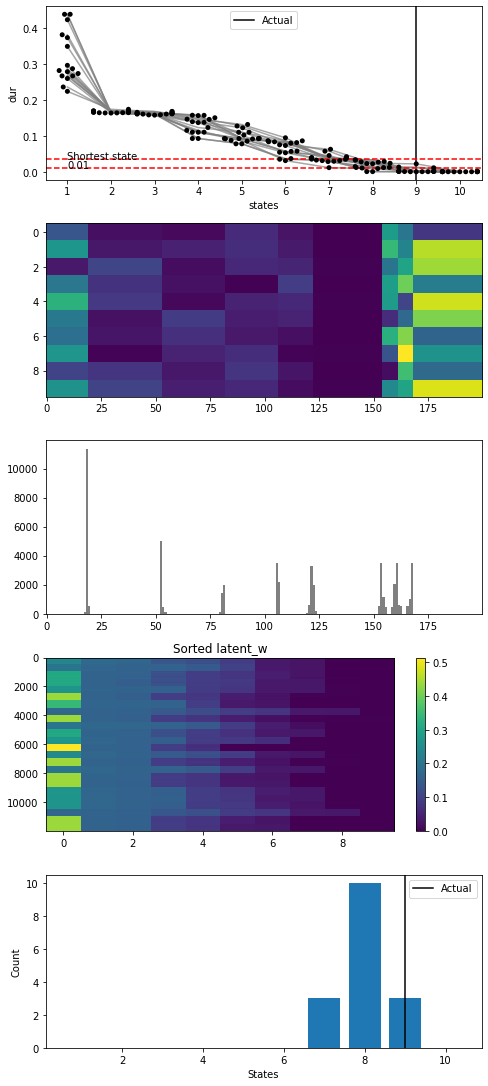

In [290]:
inds = np.array(list(np.ndindex(mean_sorted.shape)))
state_frame = pd.DataFrame(
                        dict(
                            chains = inds[:,0],
                            states = inds[:,1]+1,
                            dur = mean_sorted.flatten()
                        )
                    )

fig,ax = plt.subplots(5,1, figsize = (7,15))

sns.swarmplot(
    data = state_frame,
    x = 'states',
    y = 'dur',
    color = 'k',
    ax = ax[0]
)
ax[0].plot(mean_sorted.T, alpha = 0.7, color = 'grey')

ax[0].axvline(states-1, zorder = -1, color = 'black', label = 'Actual')
ax[0].legend()
ax[0].axhline(shortest_state, color = 'red', linestyle = '--')
ax[0].text(0, shortest_state, 'Shortest state')
ax[0].axhline(0.01, color = 'red', linestyle = '--')
ax[0].text(0, 0.01, '0.01')
# ax[0].axhline(0.05, color = 'red', linestyle = '--')
# ax[0].text(0, 0.05, '0.05')

corrected_transitions = np.cumsum(sorted_w_latent,axis=-1)
#tau_samples = np.concatenate(dpp_trace.posterior.data_vars['tau'].values)
tau_samples = dpp_trace['tau']
ax[1].imshow(true_r,aspect='auto', interpolation = 'nearest')
for x in tau_samples.T:
    ax[2].hist(x, bins = np.arange(length), color = 'grey')
ax[2].sharex(ax[1])
    
im1 = ax[3].imshow(sorted_lens, interpolation='nearest', aspect= 'auto')
ax[3].set_title('Sorted latent_w')
fig.colorbar(im1, ax=ax[3])
plt.tight_layout()

max_state_per_chain = state_frame.loc[state_frame.dur > 0.01].groupby('chains').max()
max_state_counts = max_state_per_chain.groupby('states').count()
state_vec = np.arange(1,changes+1)
counts = [max_state_counts.loc[x].values[0] if x in max_state_counts.index else 0 for x in state_vec ]
ax[4].axvline(states, zorder = 2, color = 'black', label = 'Actual')
ax[4].legend()
ax[4].bar(state_vec, counts)
ax[4].set_xlabel("States")
ax[4].set_ylabel('Count')

fig.savefig(f'/home/abuzarmahmood/Pictures/dirichlet_state_comparison/{states}_state.png')